# Tanzania - Spectral Indices for Agriculture

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import datacube
dc = datacube.Datacube(app = 'my_app')

In [2]:
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Select Landsat-7 or Landsat-8

In [3]:
platform = 'LANDSAT_8'
product = "ls8_usgs_sr_scene"

# Select a smaller region for your analysis and the time extent

In [4]:
time_extents = ('2017-01-01', '2018-01-01')

# Southern Grassland
latitude_extents = (-8.1541, -8.1272)
longitude_extents = (33.2016, 33.2545)

# Northern Grassland
# latitude_extents = (-3.4498, -3.4294)
# longitude_extents = (33.1382, 33.1713)

# Evergreen Forest
# latitude_extents = (-6.7192, -6.4026)
# longitude_extents = (35.9473, 36.2659)

# ITISO Region
# latitude_extents = (-5.899, -5.365)
# longitude_extents = (35.665, 36.317)

# PAHI Region
# latitude_extents = (-4.966, -4.394)
# longitude_extents = (35.783, 36.353)

In [5]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

## Load the dataset and the required spectral bands or other parameters

In [6]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          time = time_extents,
                          product = product, 
                          platform = platform,
                          output_crs = 'EPSG:4326', resolution=(-0.0003, 0.0003),
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [7]:
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 91, longitude: 177, time: 54)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01T07:51:34.172468 ... 2017-12-26T07:57:19.397841
  * latitude   (latitude) float64 -8.127 -8.127 -8.128 ... -8.154 -8.154 -8.154
  * longitude  (longitude) float64 33.2 33.2 33.2 33.2 ... 33.25 33.25 33.25
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 564 817
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 627 801
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 ... 451 556
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 2281 2341
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 1551 1979
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 993 1376
    pixel_qa   (time, latitude, longitude) uint16 1 1 1 1 1 ... 352 352 352 352
Attributes:
    crs:      EPSG:4326

>### Masking out Clouds

In [8]:
import xarray as xr  
import numpy as np

In [9]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

> **Median Mosaic**  
>  Masks clouds from imagery using the median valued cloud-free pixels in the time series  

In [10]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

In [11]:
from utils.data_cube_utilities.dc_rgb import rgb

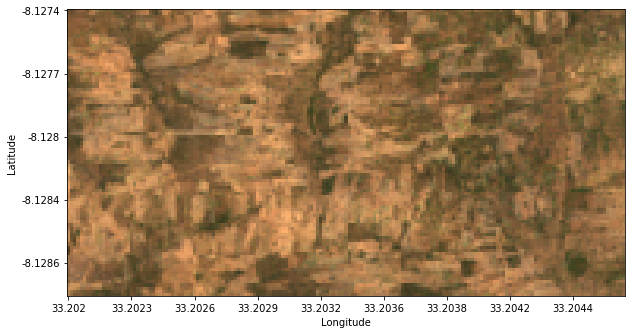

In [12]:
rgb(median_composite)

> **Max NDVI Mosaic**  
>  Masks clouds from imagery using the Max NDVI across time for cloud-free pixels in the time series  

In [13]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic
cloud_mask_xr = xr.DataArray(cloud_mask, dims = ['time', 'latitude', 'longitude'])
max_ndvi_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask_xr)
min_ndvi_composite = create_min_ndvi_mosaic(cleaned_dataset, cloud_mask)


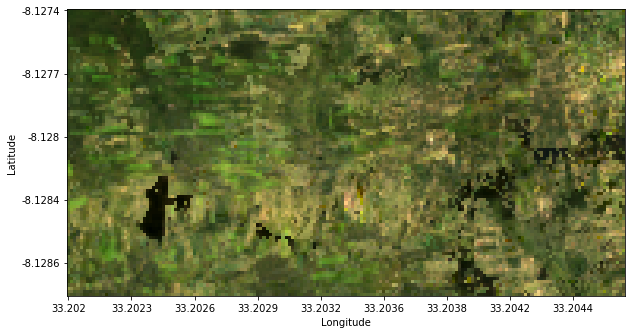

In [14]:
rgb(max_ndvi_composite)

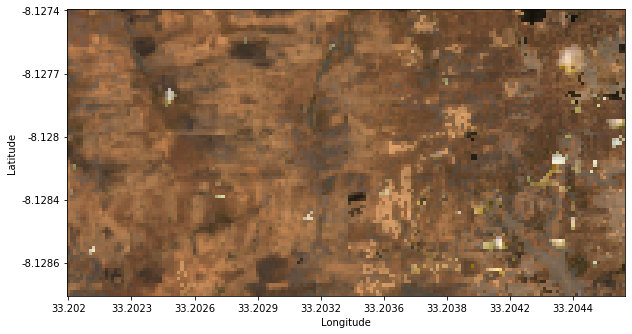

In [15]:
rgb(min_ndvi_composite)

# Fractional Cover  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic.  

In [16]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(median_composite, clean_mask = np.ones(median_composite.pixel_qa.shape).astype(np.bool)) 

## Plotting Fractional Cover Results
Plot Bare Soil (bs), Photosynthetic Vegetation (pv) or Non Photosynthetic Vegetation (npv)
<br>
Plot a False Color RGB result where RGB = bs/pv/npv.
<br>
Bare Soil = RED, PV = GREEN, NPV = BLUE

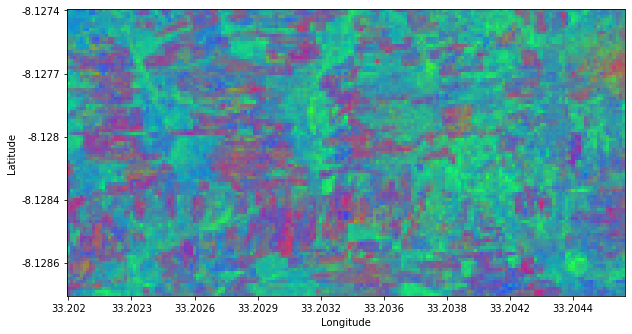

In [17]:
rgb(frac_classes, bands = ['bs', 'pv', 'npv']) 

# Spectral Indices

<b>Normalized Difference Vegetation Index (NDVI)</b>

The Normalized Difference Vegetation Index (NDVI) is an index of plant “greenness” or photosynthetic activity, and is one of the most commonly used vegetation indices. Vegetation indices are based on the observation that different surfaces reflect different types of light differently. Photosynthetically active vegetation, in particular, absorbs most of the red light that hits it while reflecting much of the near infrared light. Vegetation that is dead or stressed reflects more red light and less near infrared light. Likewise, non-vegetated surfaces have a much more even reflectance across the light spectrum. 

In [18]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

<b>Enhanced Vegetation Index (EVI)</b>

The enhanced vegetation index (EVI) was developed as an alternative vegetation index to address some of the limitations of the NDVI. The EVI was specifically developed to: (a) be more sensitive to changes in areas having high biomass (a serious shortcoming of NDVI), (b) Reduce the influence of atmospheric conditions on vegetation index values, and (c) correct for canopy background signals.

EVI tends to be more sensitive to plant canopy differences like leaf area index (LAI), canopy structure, and plant phenology and stress than does NDVI which generally responds just to the amount of chlorophyll present. 

In [19]:
def EVI(dataset):
        return (2.5 * ((dataset.nir - dataset.red)/((dataset.nir  + (6.0 * dataset.red) - (7.5 * dataset.blue) + 1.0)))).rename("EVI")

In [20]:
ndvi = NDVI(max_ndvi_composite)  # Dense Vegetation - Greens
evi = EVI(max_ndvi_composite) # Dense Vegetation - Greens

In [21]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


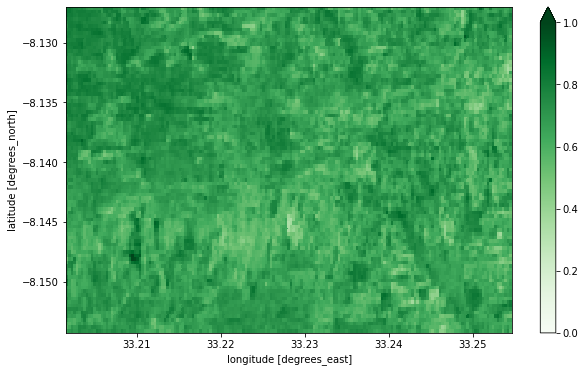

In [22]:
(ndvi).plot(figsize=(10,6), cmap = "Greens", vmin=0.0, vmax=1.0)

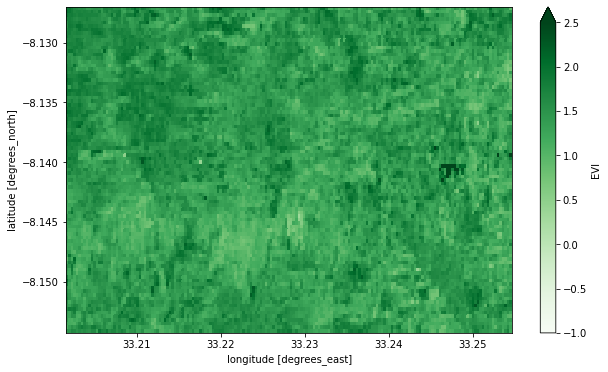

In [23]:
(evi).plot(figsize=(10,6), cmap = "Greens", vmin=-1.0, vmax=2.5)

## Create a threshold plot
First we will define a minimum threshold and a maximum threshold. Then you will create a plot that colors the region between the threshold a single color (e.g. red) and the region outside the threshold will be BLACK or WHITE. Also, we will calculate the % of pixels and the number of pixels in the threshold range.

In [24]:
from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

### Plot Threshold Product

In [25]:
# Define the threshold region bounds

# NDVI range = 0.0 to 1.0 (grassland 0.2 to 0.6, forests 0.6 to 0.9)
# minimum_threshold = 0.1
# maximum_threshold = 0.3

# EVI range = -1.0 to 2.5 (healthy vegetation is 0.2 to 0.8)
# minimum_threshold = 0.2
# maximum_threshold = 0.8

# Frac Cover (pv,npv,bs) = 0 to 100 
minimum_threshold = 30.0
maximum_threshold = 100.0

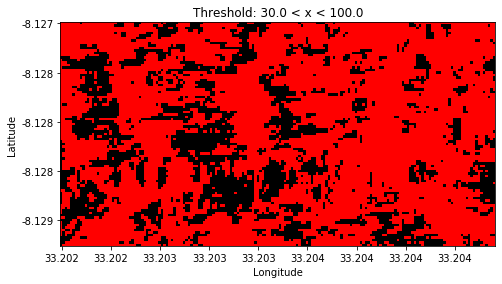

In [26]:
# Plot the threshold product using a cloud-filtered mosaic
# threshold_plot(ndvi, minimum_threshold, maximum_threshold, width = 8)
# threshold_plot(evi, minimum_threshold, maximum_threshold, width = 8)
threshold_plot(frac_classes.pv, minimum_threshold, maximum_threshold, width = 8)